# Along isopycnal spice spectra

Internal waves project as a signal on all tracers when viewing the data at a fixed depth, and can be a large part of the signal. However, if the waves are largely a linear superimposition on some background balanced flow then it makes sense to remove them to understand the signatures of the balanced motions. This can be done by looking at properties along isopycnals. 

Here we specifically look at spice by considering the:  
a) Frequency and wavenumber spectra  


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_659_rho = xr.open_dataset('data/sg_O2_659_isopycnal_grid_4m_27_sept_2021.nc')
ds_660_rho = xr.open_dataset('data/sg_O2_660_isopycnal_grid_4m_27_sept_2021.nc')

In [4]:
ds_659_rho

<xarray.Dataset>
Dimensions:       (rho_grid: 901, dives: 912)
Coordinates:
  * rho_grid      (rho_grid) float64 26.9 26.9 26.9 26.9 ... 27.8 27.8 27.8 27.8
  * dives         (dives) float64 2.0 2.5 3.0 3.5 ... 461.0 461.5 462.0 462.5
Data variables:
    ctd_pressure  (rho_grid, dives) float64 ...
    CT            (rho_grid, dives) float64 ...
    SA            (rho_grid, dives) float64 ...
    Oxygen        (rho_grid, dives) float64 ...
    latitude      (rho_grid, dives) float64 ...
    longitude     (rho_grid, dives) float64 ...
    days          (rho_grid, dives) float64 ...

In [5]:
# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)
# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
#dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')
ds_660_rho['Spice'] = 2*1000*alpha*dCT

alpha = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
# remove a mean per isopycnal
dCT = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
#dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')
ds_659_rho['Spice'] = 2*1000*alpha*dCT

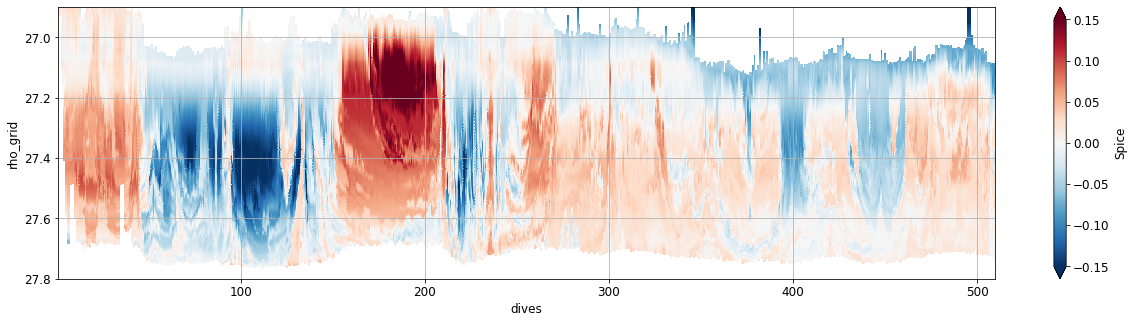

In [7]:
plt.figure(figsize=(21,5))
ds_660_rho['Spice'].plot(vmin=-1.5e-1)
plt.gca().invert_yaxis()
plt.grid()

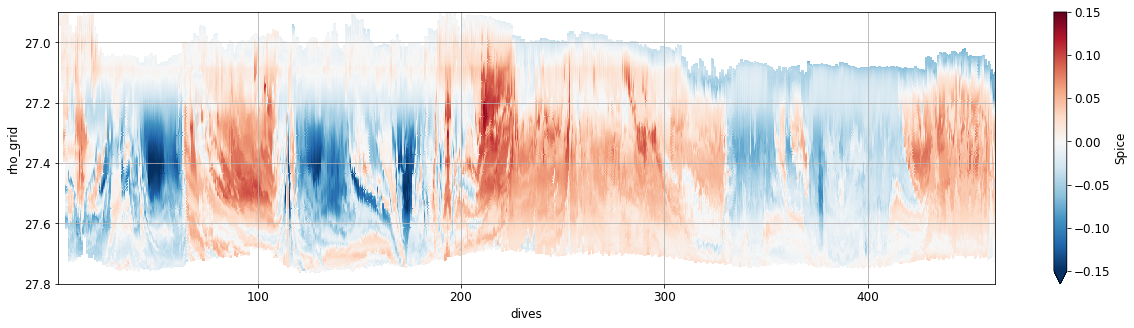

In [8]:
plt.figure(figsize=(21,5))
ds_659_rho['Spice'].plot(vmin=-1.5e-1)
plt.gca().invert_yaxis()
plt.grid()

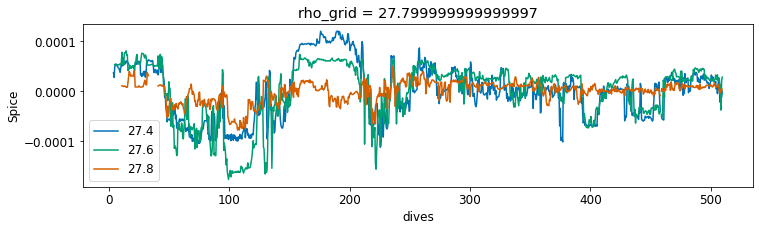

In [10]:
plt.figure(figsize=(12,3))
ds_660_rho.Spice.sel(rho_grid=27.4, method='nearest').plot(label='27.4')
ds_660_rho.Spice.sel(rho_grid=27.6, method='nearest').plot(label='27.6')
ds_660_rho.Spice.sel(rho_grid=27.8, method='nearest').plot(label='27.8')
plt.legend()

### Frequency spectra

In [9]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(121, 205, 1/24)

   
    for i in range(len(ds.rho_grid)):
        ds_temp =ds.isel(rho_grid=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var], bounds_error=False)
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int

In [10]:
ds_660_time = xr.merge([interp_time(ds_660_rho,'ctd_pressure'),
                        interp_time(ds_660_rho,'Spice'),
                        interp_time(ds_660_rho,'CT'),
                        interp_time(ds_660_rho,'SA')])

In [11]:
ds_659_time = xr.merge([interp_time(ds_659_rho,'ctd_pressure'),
                        interp_time(ds_659_rho,'Spice'),
                        interp_time(ds_659_rho,'CT'),
                        interp_time(ds_659_rho,'SA')])

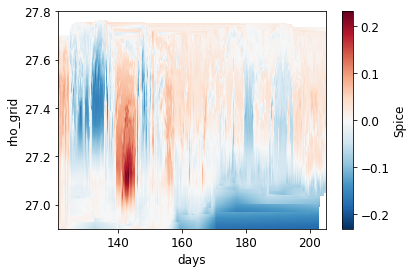

In [28]:
ds_660_time.Spice.plot()

In [14]:
import spectrum

In [15]:
def mtm_psd(ds, var):
    NW=10 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('days') # remove a time mean 
    
    n=0 # counter to make sure that xarray is initialized when first calc is done
    for i in range(len(da.rho_grid)): 
        
        data = da.isel(rho_grid=i)
        
        if len(data.where(np.isnan(data), drop=True))==0:
        
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data), sampling=1/3600)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['freq'],
                                            coords={'freq': 24*3600*np.array(mtm_obj.frequencies()), # convert to per day
                                                    'rho_grid': data.rho_grid}).rename(var)

            if n==0:
                da_var_freq = da_var_freq_temp
                n=n+1
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='rho_grid')
    
    return da_var_freq

In [16]:
ds_660_freq = xr.merge([mtm_psd(ds_660_time, 'Spice'),
                        mtm_psd(ds_660_time, 'ctd_pressure'),
                        mtm_psd(ds_660_time, 'CT'),
                        mtm_psd(ds_660_time, 'SA')])

In [17]:
ds_659_freq = xr.merge([mtm_psd(ds_659_time, 'Spice'),
                        mtm_psd(ds_659_time, 'ctd_pressure'),
                        mtm_psd(ds_659_time, 'CT'),
                        mtm_psd(ds_659_time, 'SA')])

In [18]:
ds_660_freq

<xarray.Dataset>
Dimensions:       (freq: 1009, rho_grid: 617)
Coordinates:
  * freq          (freq) float64 0.0 0.0119 0.02381 0.03571 ... 11.98 11.99 12.0
  * rho_grid      (rho_grid) float64 27.08 27.08 27.08 27.09 ... 27.7 27.7 27.7
Data variables:
    Spice         (rho_grid, freq) float64 0.5045 0.4989 ... 2.188e-06 2.027e-06
    ctd_pressure  (rho_grid, freq) float64 3.479e+05 3.477e+05 ... 3.276 3.157
    CT            (rho_grid, freq) float64 16.9 16.72 ... 5.464e-05 5.062e-05
    SA            (rho_grid, freq) float64 0.1892 0.1871 ... 5.585e-07 5.175e-07

In [23]:
ds_659_freq

<xarray.Dataset>
Dimensions:       (freq: 1009, rho_grid: 670)
Coordinates:
  * freq          (freq) float64 0.0 0.0119 0.02381 0.03571 ... 11.98 11.99 12.0
  * rho_grid      (rho_grid) float64 27.06 27.06 27.06 ... 27.72 27.73 27.73
Data variables:
    Spice         (rho_grid, freq) float64 0.164 0.1648 ... 7.859e-07 7.919e-07
    ctd_pressure  (rho_grid, freq) float64 4.528e+05 4.561e+05 ... 2.087 2.15
    CT            (rho_grid, freq) float64 6.263 6.29 ... 1.865e-05 1.879e-05
    SA            (rho_grid, freq) float64 0.06772 0.06804 ... 1.893e-07

In [26]:
ds_mean_freq = 0.5*(ds_660_freq + ds_659_freq)

Text(0.5, 1.0, '')

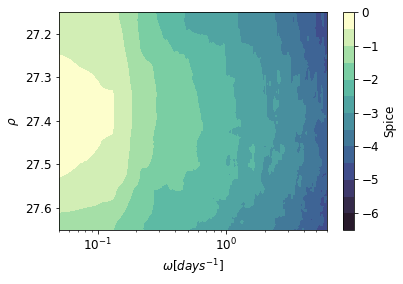

In [36]:
np.log10(ds_mean_freq.Spice).plot.contourf(levels=13, cmap=cmo.deep_r)
plt.xscale('log')
plt.xlim([1/20, 24/4])
plt.gca().invert_yaxis()
plt.ylim([27.65, 27.15])

plt.ylabel(r'$\rho$')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('')

In [68]:
npres = len(ds_mean_freq.rho_grid)
m_mean = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_freq.Spice.isel(rho_grid=i).sel(freq=slice(2/10, 24/12))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_mean[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_freq.Spice.isel(rho_grid=i).sel(freq=slice(2/10, 24/12))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_660_freq.Spice.isel(rho_grid=i).sel(freq=slice(2/10, 24/12))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)

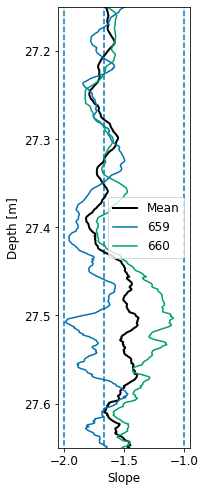

In [74]:
plt.figure(figsize=(3,7))

plt.plot(m_mean, ds_mean_freq.rho_grid, color='k', linewidth=2, label='Mean')
plt.plot(m_659, ds_mean_freq.rho_grid, label='659' )
plt.plot(m_660, ds_mean_freq.rho_grid, label='660')
plt.gca().invert_yaxis()

plt.vlines([-2, -5/3, -1], 27.1, 27.7, linestyles='--')
plt.legend()
#plt.xlim([-2.2, -1.2])
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
#plt.ylim([950, 0])
plt.ylim([27.65, 27.15])
plt.tight_layout()

#plt.savefig('figures/figure_rho_spec_panel2.pdf')


(0.05, 8.0)

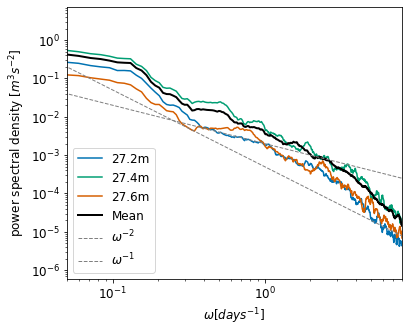

In [41]:
plt.figure(figsize=(6,5))

for i in [27.2, 27.4, 27.6]:
        ds_mean_freq.Spice.sel(rho_grid=i ,method='nearest').plot(label=str(i)+'m')

ds_mean_freq.Spice.sel(rho_grid=slice(27.3,27.6)).mean('rho_grid').plot(linewidth=2, color='k', label='Mean')        
# Some lines        
freq = ds_660_freq.freq
plt.plot(freq, 5e-4*freq**-2, label='$\omega^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 2e-3*freq**-1, label='$\omega^{-1}$', linestyle='--', color='gray', linewidth=1)
#plt.plot(freq, 8e-6*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

#plt.vlines([24/12], 1e-12, 1e-6, linestyles='--', linewidth=1, label='12 hour')
#plt.vlines([24/15, 24/12, 24/24], 1e-6, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.legend(loc='lower left')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
#plt.title('Absolute Salinity Variance')

#plt.ylim([1e-12, 1e-6])
plt.xlim([1/20, 24/3])

#### Wavenumber spectra

In [56]:
# select straight section
ds_660_scX = ds_660_rho.sel(dives=slice(225, 337))#.sel(ctd_pressure=500, method='nearest')

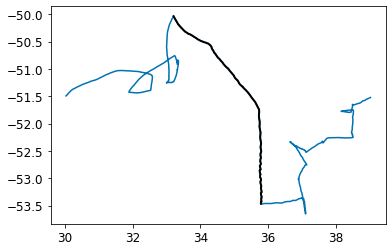

In [57]:
plt.plot(ds_660_rho.longitude.mean('rho_grid'), 
         ds_660_rho.latitude.mean('rho_grid') )
plt.plot(ds_660_scX.longitude.mean('rho_grid'), 
         ds_660_scX.latitude.mean('rho_grid'), linewidth=2, color='k' )

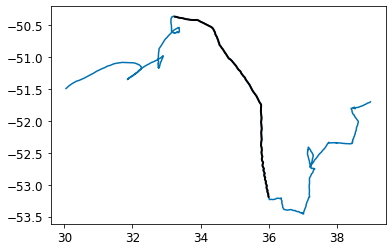

In [87]:

ds_659_scX = ds_659_rho.sel(dives=slice(182, 287))#.sel(ctd_pressure=500, method='nearest')

plt.plot(ds_659_rho.longitude.mean('rho_grid'), 
         ds_659_rho.latitude.mean('rho_grid') )
plt.plot(ds_659_scX.longitude.mean('rho_grid'), 
         ds_659_scX.latitude.mean('rho_grid'), linewidth=2, color='k' )

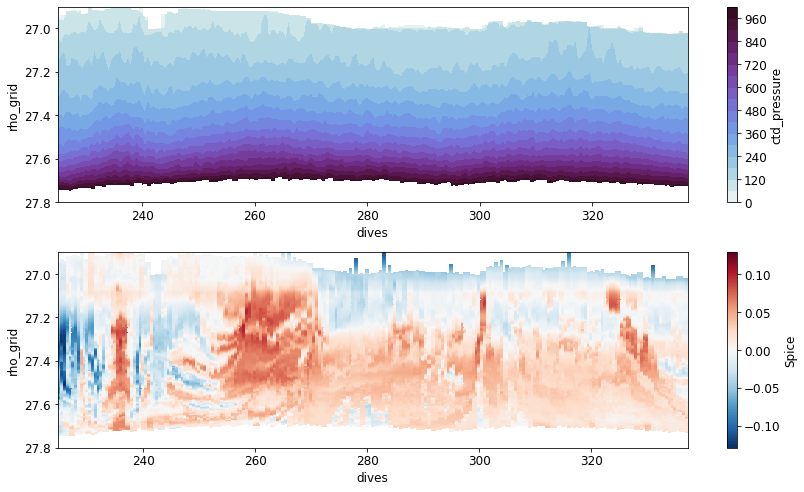

In [88]:
plt.figure(figsize=(12, 7))
plt.subplot(211)
ds_660_scX.ctd_pressure.plot.contourf(levels=18, cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.subplot(212)
ds_660_scX.Spice.plot()
plt.gca().invert_yaxis()

plt.tight_layout()


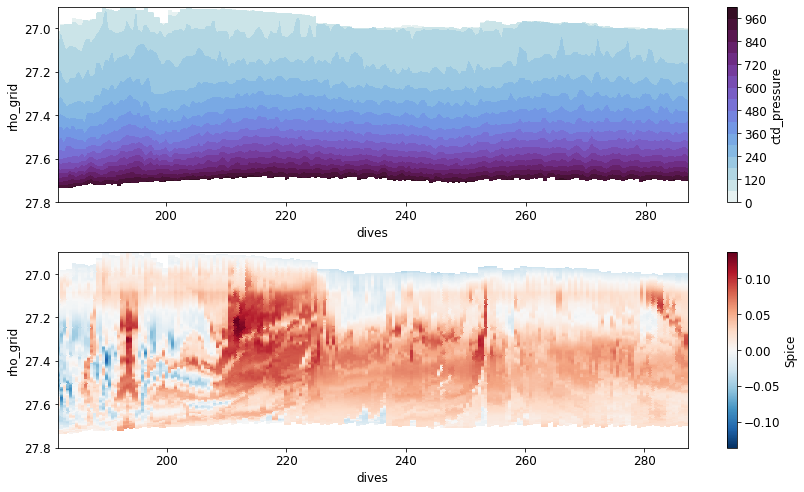

In [89]:
plt.figure(figsize=(12, 7))
plt.subplot(211)
ds_659_scX.ctd_pressure.plot.contourf(levels=18, cmap=cmo.dense)
plt.gca().invert_yaxis()

plt.subplot(212)
ds_659_scX.Spice.plot()
plt.gca().invert_yaxis()

plt.tight_layout()


In [93]:
def interp_distance(ds, var): 
    #dist_grid = np.arange(20e3, 475e3, 500)
    dist_grid = np.arange(0, 400e3, 500)
    
    for i in range(len(ds.rho_grid)): 
        ds_temp = ds.isel(rho_grid=i)
        
        
        #distance = np.cumsum(gt.utils.distance(np.insert(ds_temp.longitude, 0, 33), 
        #                                       np.insert(ds_temp.latitude, 0, -50)))
        #data = np.insert(ds_temp[var].values, 0 , 0)
                           
        distance = np.cumsum(gt.utils.distance(ds_temp.longitude, ds_temp.latitude)) 
        data = ds_temp[var].values
        f = interpolate.interp1d(distance, data)
        
        var_int = f(dist_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["distance"],
                                 coords={"distance": dist_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int
            

In [94]:
ds_660_dist_sec = xr.merge( [interp_distance(ds_660_scX, 'Spice'),
                             interp_distance(ds_660_scX, 'ctd_pressure')] )
#                             interp_distance(ds_660_scX, 'SA')] )

In [95]:
ds_659_dist_sec = xr.merge( [interp_distance(ds_659_scX, 'Spice'),
                             interp_distance(ds_659_scX, 'ctd_pressure')] )

In [96]:
def mtm_psd(ds, var):
    NW=7 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('distance') # remove a distance mean 
    n=0
    for i in range(len(da.rho_grid)): 

        data = da.isel(rho_grid=i)
        
        if len(data.where(np.isnan(data), drop=True))==0: 
        
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data.values), sampling=1/500)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['k'],
                                            coords={'k': np.array(mtm_obj.frequencies()), # convert to per day
                                                    'rho_grid': data.rho_grid}).rename(var)

            if n==0:
                da_var_freq = da_var_freq_temp
                n=n+1
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='rho_grid')
    
    return da_var_freq

In [97]:
ds_660_wnum = xr.merge([mtm_psd(ds_660_dist_sec, 'ctd_pressure'),
                        mtm_psd(ds_660_dist_sec, 'Spice')] )

In [98]:
ds_659_wnum = xr.merge([mtm_psd(ds_659_dist_sec, 'ctd_pressure'),
                        mtm_psd(ds_659_dist_sec, 'Spice')] )

In [101]:
ds_mean_wnum = 0.5*(ds_659_wnum + ds_660_wnum)

In [102]:
ds_mean_wnum

<xarray.Dataset>
Dimensions:       (rho_grid: 661, k: 401)
Coordinates:
  * rho_grid      (rho_grid) float64 27.02 27.02 27.02 ... 27.67 27.68 27.68
  * k             (k) float64 0.0 2.5e-06 5e-06 ... 0.000995 0.0009975 0.001
Data variables:
    ctd_pressure  (rho_grid, k) float64 1.379e+04 1.372e+04 ... 2.165 2.337
    Spice         (rho_grid, k) float64 0.03444 0.03452 ... 7.542e-07 8.118e-07

In [105]:
npres = len(ds_mean_freq.rho_grid)
m_mean = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_wnum.Spice.isel(rho_grid=i).sel(k=slice(1/50e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_mean[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_wnum.Spice.isel(rho_grid=i).sel(k=slice(1/50e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_660_wnum.Spice.isel(rho_grid=i).sel(k=slice(1/50e3, 1/5e3))
    x = ds_temp.k.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)

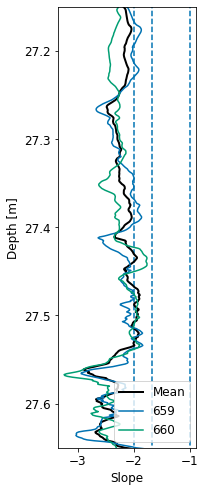

In [106]:
plt.figure(figsize=(3,7))

plt.plot(m_mean, ds_mean_freq.rho_grid, color='k', linewidth=2, label='Mean')
plt.plot(m_659, ds_mean_freq.rho_grid, label='659' )
plt.plot(m_660, ds_mean_freq.rho_grid, label='660')
plt.gca().invert_yaxis()

plt.vlines([-2, -5/3, -1], 27.1, 27.7, linestyles='--')
plt.legend()
#plt.xlim([-2.2, -1.2])
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
#plt.ylim([950, 0])
plt.ylim([27.65, 27.15])
plt.tight_layout()

#plt.savefig('figures/figure_rho_spec_panel2.pdf')


Text(0.5, 1.0, 'PE PSD')

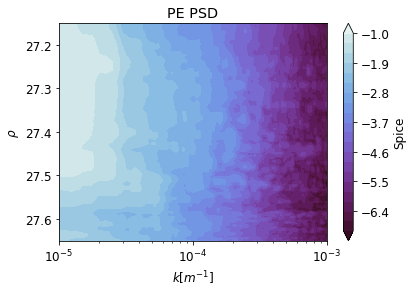

In [112]:
np.log10(ds_mean_wnum.Spice).plot.contourf(levels=np.linspace(-7, -1, 21), cmap=cmo.dense_r)
plt.xscale('log')
plt.xlim([1e-5, 1e-3])

plt.gca().invert_yaxis()

plt.ylim([27.65, 27.15])
plt.ylabel(r'$\rho$')
plt.xlabel('$k [m^{-1}]$')
plt.title('PE PSD')


(1e-05, 0.001)

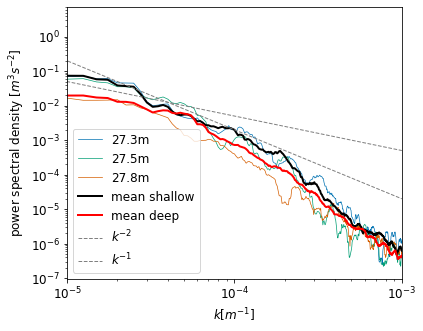

In [107]:
plt.figure(figsize=(6,5))
for i in [27.3, 27.5, 27.8]:
        ds_660_wnum.Spice.sel(rho_grid=i ,method='nearest').plot(label=str(i)+'m', linewidth=.7)

ds_660_wnum.Spice.sel(rho_grid=slice(27.3, 27.5)).mean('rho_grid').plot(label='mean shallow', linewidth=2, color='k')        
ds_660_wnum.Spice.sel(rho_grid=slice(27.5, 27.7)).mean('rho_grid').plot(label='mean deep', linewidth=2, color='r')        
# Some lines        
freq = ds_660_wnum.k
plt.plot(freq, 2e-11*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 5e-7*freq**-1, label='$k^{-1}$', linestyle='--', color='gray', linewidth=1)
#plt.plot(freq, 4e-2*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
#plt.vlines([24/15, 24/12, 24/24], 1e2, 1e8, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$k [m^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
#plt.title('Potential Energy')

#plt.ylim([1e-13, 1e-7])
plt.xlim([1/100e3, 1/1e3])

#plt.savefig('figures/PE_line_spec.pdf')

## Frequency spectra for the sectioned out part

We want to know if the slightly steeper seen in the wavenumber (-2) vs frequency (-1.6) is simply a result of sampling over different regions.

In [116]:
ds_660_scX.days.min().values,ds_660_scX.days.max().values 

(array(148.84256933), array(168.93280434))

In [117]:
ds_659_scX.days.min().values,ds_659_scX.days.max().values 

(array(148.74488064), array(168.87067279))

In [118]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time_section(ds, var): 
    time_grid = np.arange(149, 168, 1/24)

   
    for i in range(len(ds.rho_grid)):
        ds_temp =ds.isel(rho_grid=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var], bounds_error=False)
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int

In [126]:
ds_660_time_sec = xr.merge([interp_time_section(ds_660_scX,'ctd_pressure'),
                            interp_time_section(ds_660_scX,'Spice')])

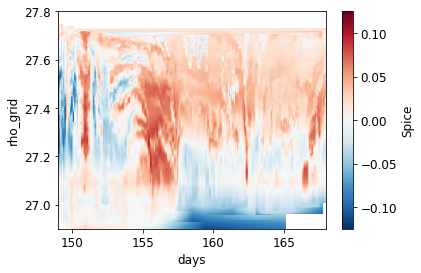

In [127]:
ds_660_time_sec.Spice.plot()

In [128]:
ds_659_time_sec = xr.merge([interp_time_section(ds_659_scX,'ctd_pressure'),
                            interp_time_section(ds_659_scX,'Spice')])

In [129]:
def mtm_psd_freq(ds, var):
    NW=10 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('days') # remove a time mean 
    
    n=0 # counter to make sure that xarray is initialized when first calc is done
    for i in range(len(da.rho_grid)): 
        
        data = da.isel(rho_grid=i)
        
        if len(data.where(np.isnan(data), drop=True))==0:
        
            mtm_obj = spectrum.MultiTapering(data.values,
                              NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                              NFFT = len(data), sampling=1/3600)
            mtm_obj.run()
            #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 

            da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                            dims=['freq'],
                                            coords={'freq': 24*3600*np.array(mtm_obj.frequencies()), # convert to per day
                                                    'rho_grid': data.rho_grid}).rename(var)

            if n==0:
                da_var_freq = da_var_freq_temp
                n=n+1
            else:
                da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='rho_grid')
    
    return da_var_freq

In [130]:
ds_660_freq_sec = xr.merge([mtm_psd_freq(ds_660_time_sec, 'Spice')])

In [132]:
ds_659_freq_sec = xr.merge([mtm_psd_freq(ds_659_time_sec, 'Spice')])

In [133]:
ds_mean_freq_sec = 0.5*(ds_659_freq_sec + ds_660_freq_sec)

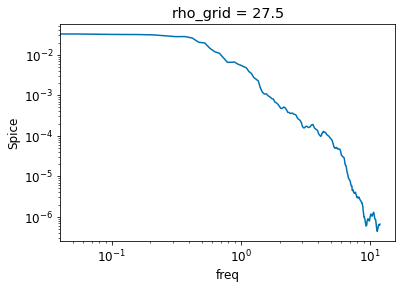

In [136]:
ds_mean_freq_sec.Spice.sel(rho_grid=27.5).plot()
plt.xscale('log')
plt.yscale('log')

In [137]:
npres = len(ds_mean_freq.rho_grid)
m_mean = np.zeros((npres,))
m_659 = np.zeros((npres,))
m_660 = np.zeros((npres,))

for i in range(npres):
    ds_temp  = ds_mean_freq_sec.Spice.isel(rho_grid=i).sel(freq=slice(8/10, 24/10))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_mean[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_659_freq_sec.Spice.isel(rho_grid=i).sel(freq=slice(8/10, 24/10))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_659[i],b = np.polyfit(np.log(x), np.log(y),1)
    
    ds_temp  = ds_660_freq_sec.Spice.isel(rho_grid=i).sel(freq=slice(8/10, 24/10))
    x = ds_temp.freq.values
    y = ds_temp.values
    m_660[i],b = np.polyfit(np.log(x), np.log(y),1)

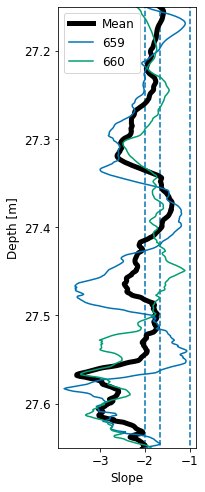

In [139]:
plt.figure(figsize=(3,7))

plt.plot(m_mean, ds_mean_freq.rho_grid, color='k', linewidth=5, label='Mean')
plt.plot(m_659, ds_mean_freq.rho_grid, label='659' )
plt.plot(m_660, ds_mean_freq.rho_grid, label='660')
plt.gca().invert_yaxis()

plt.vlines([-2, -5/3, -1], 27.1, 27.7, linestyles='--')
plt.legend()
#plt.xlim([-2.2, -1.2])
plt.xlabel('Slope')
plt.ylabel('Depth [m]')
#plt.ylim([950, 0])
plt.ylim([27.65, 27.15])
plt.tight_layout()

#plt.savefig('figures/figure_rho_spec_panel2.pdf')


The broad result from the above analysis is that the spectral slope of spice along isopycnals is -2, which is line with previous studies. 

It is also worth noting that the spice and its gradients are relative large even near the deepest levels that were measured. 